<a href="https://colab.research.google.com/github/eldor-fozilov/ethereum-gas-price-prediction/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pmdarima

In [ ]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
dataset = pd.read_csv('average_gas.csv')
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.set_index('timestamp', inplace = True)
dataset_90days = pd.read_csv('train_df_90days.csv')

In [ ]:
dataset.head()

,average_gas_fee,avgGas
timestamp,,
2022-04-26 13:00:00,46.670,80868.519046
2022-04-26 14:00:00,78.150,85449.256791
2022-04-26 15:00:00,81.885,82192.413722
2022-04-26 16:00:00,67.235,82451.786800
2022-04-26 17:00:00,56.095,84236.446559


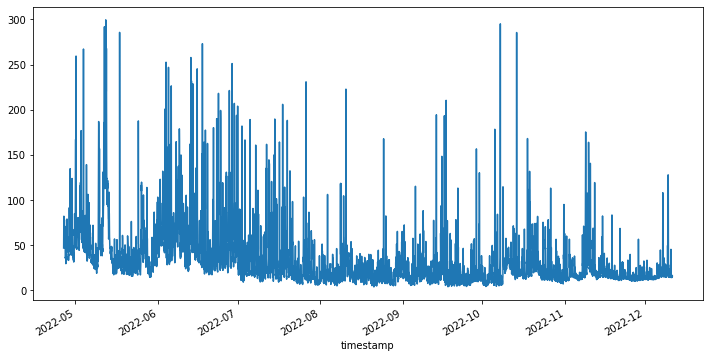

In [ ]:
dataset['average_gas_fee'].plot(figsize = (12,6));

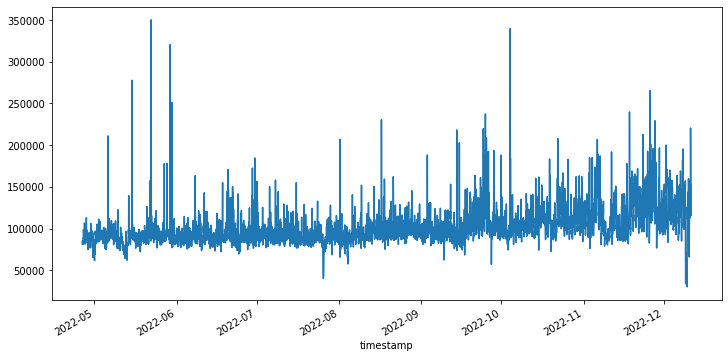

In [ ]:
dataset['avgGas'].plot(figsize = (12,6));

In [ ]:
dataset_90days.head()

,timestamp,average_gas_fee,avgGas,Bitcoin Price (USD),Ethereum Price (USD)
0,2022-09-12 10:00:00,10.585,92232.945200,22195.69118,1750.655946
1,2022-09-12 11:00:00,30.230,88143.438267,22180.53379,1746.531098
2,2022-09-12 12:00:00,33.410,82982.461422,22292.74291,1751.864674
3,2022-09-12 13:00:00,25.225,84544.989353,22359.17007,1747.678093
4,2022-09-12 14:00:00,52.245,89251.971497,22391.44726,1752.387514


In [ ]:
df_log = np.log(dataset['average_gas_fee'])

**During EDA, we saw that ASF for log differenced data "cuts off" after 1 lag, however PACF does not die out and stays significant. That makes hard for us to pick the orders for AR(p) or MA(q). We will first try to build a simple model MA(1) and then a seasonal ARIMA model with daily frequency (24) with different p,q,P,Q orders. After that we will run auto arima on our log data, without including the seasonality term, and compare its best outcome with eariler models.**

## Model Development and Evaluation for Average Gas Price (without exogenous variables)

## Model Building Part (Traditional Models)

In [ ]:
vanilla_model = sm.tsa.arima.ARIMA(df_log, order = (0,1,1)).fit()

print(vanilla_model.summary())

                               SARIMAX Results                                
Dep. Variable:        average_gas_fee   No. Observations:                 5487
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3252.690
Date:                Wed, 14 Dec 2022   AIC                           6509.379
Time:                        11:35:01   BIC                           6522.599
Sample:                             0   HQIC                          6513.991
                               - 5487                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4534      0.009    -52.791      0.000      -0.470      -0.437
sigma2         0.1916      0.002     82.523      0.000       0.187       0.196
Ljung-Box (L1) (Q):                   3.17   Jarque-

In [ ]:
model_24 = sm.tsa.arima.ARIMA(df_log, order= (0,1,1), seasonal_order = (0,1,1,24)).fit()
print(model_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5487
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -2901.973
Date:                          Wed, 14 Dec 2022   AIC                           5809.946
Time:                                  11:40:07   BIC                           5829.763
Sample:                                       0   HQIC                          5816.861
                                         - 5487                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6791      0.008    -86.587      0.000      -0.694      -0.664
ma.S.L24      -0.9351      0.004   -216.286      0.

**Let's add AR lag1 term also to the above model and see the results.**

In [ ]:
model_24 = sm.tsa.arima.ARIMA(df_log, order= (1,1,1), seasonal_order = (1,1,1,24)).fit()
print(model_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5487
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -2831.408
Date:                          Wed, 14 Dec 2022   AIC                           5672.816
Time:                                  11:35:37   BIC                           5705.844
Sample:                                       0   HQIC                          5684.340
                                         - 5487                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2658      0.013     21.057      0.000       0.241       0.291
ma.L1         -0.8586      0.008   -107.247      0.

**We can see that the variable ar.S.L24 is statistically insignificant, so we don't need to include that variable in our model.**

In [ ]:
model_24 = sm.tsa.arima.ARIMA(df_log, order= (1,1,1), seasonal_order = (0,1,1,24)).fit()
print(model_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5487
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -2831.487
Date:                          Wed, 14 Dec 2022   AIC                           5670.974
Time:                                  11:39:02   BIC                           5697.396
Sample:                                       0   HQIC                          5680.193
                                         - 5487                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2660      0.013     21.073      0.000       0.241       0.291
ma.L1         -0.8586      0.008   -107.267      0.

In [ ]:
model_auto = pm.auto_arima(df_log, d=1,
                      start_p=0, start_q=0, max_order = 6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7435.028, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6737.581, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6511.373, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7433.029, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6491.734, Time=3.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6197.806, Time=10.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6572.199, Time=0.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6171.480, Time=15.35 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6522.557, Time=1.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=6172.204, Time=14.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6200.343, Time=7.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6181.662, Time=10.90 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6516.895, Time=2.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6172.322, Time=16.40 sec
 ARIMA(3,1,1)(0,0,0)[0]     

**The optimal model here is ARIMA(3,1,1), which has AIC of 6171.480. However, the seasonal ARIMA(1,1,1)(0,1,1,24) that we built earlier has a better AIC of approximately 5672. So we will choose this model.**


In [ ]:
model_24 = sm.tsa.arima.ARIMA(df_log, order= (3,1,1), seasonal_order = (0,1,1,24))
results_24 = model_24.fit()

print(results_24.summary())

                                    SARIMAX Results                                     
Dep. Variable:                  average_gas_fee   No. Observations:                 5487
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -2807.212
Date:                          Wed, 14 Dec 2022   AIC                           5626.425
Time:                                  11:47:54   BIC                           5666.058
Sample:                                       0   HQIC                          5640.253
                                         - 5487                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3083      0.012     25.428      0.000       0.285       0.332
ar.L2          0.0943      0.013      7.104      0.

## Residual Analysis Part

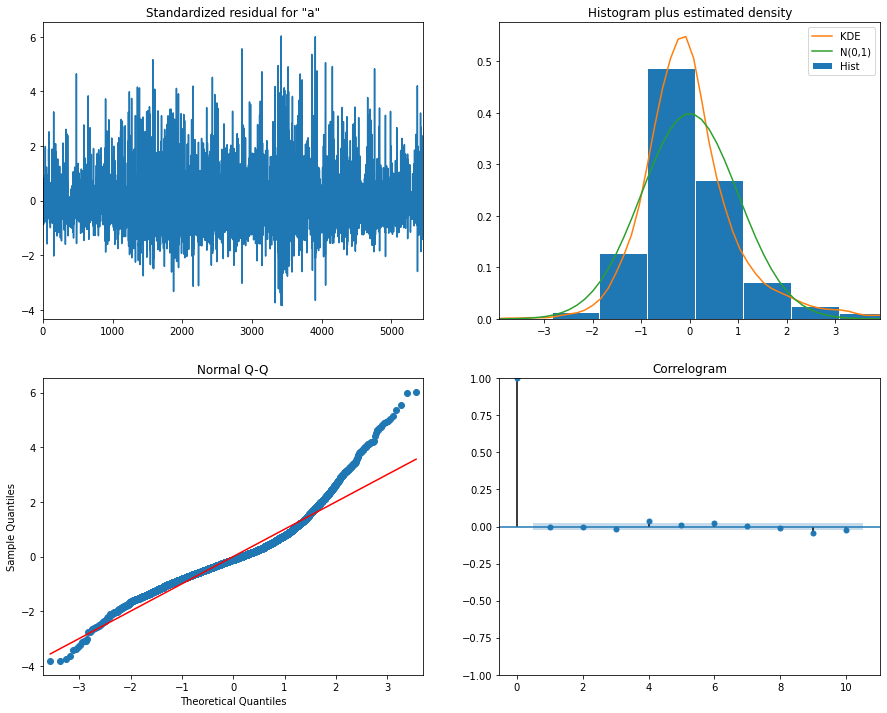

In [ ]:
results_24.plot_diagnostics(figsize=(15,12))
plt.show()

## Deep Learning Models